In [2]:
# Import Pandas for data structure manipulations.
import pandas as pd

# Import NumPy for numerical analysis.
import numpy as np

# Import a timer.
import time

from category_encoders import TargetEncoder

# Import the train_test_split, cross-validation, and grid search modules from Scikit-Learn.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Import the One-Hot Encoder, Target Encoder, StandardScaler for later categorical to numeric encoding.
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Import the column transformer that can be used for scaling purposes in later steps.
from sklearn.compose import make_column_transformer

# Import the pipeline module for step-wise transformations in later steps.
from sklearn.pipeline import make_pipeline

# Import the mean_squared_error module from Scikit-Learn as a quick error metric.
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error

# Import DecisionTreeClassifer and tree visualizatoin methods from Scikit-Learn.
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Use the experimental method in Scikit-Learn to enable HistGradientBoostingClassifier.
from sklearn.experimental import enable_hist_gradient_boosting

# Import the RandomForestClassifier, GradientBoostingClassifier, and HistGradientBoostingClassifier from Scikit-Learn.
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

# Import the XGBoost module from Scikit-Learn. Be sure to 'brew install cmake' in CLI.
# Next, 'pip install xgboost' in CLI or do a '!pip install xgboost' in iPython. This makes XGBoost accessible.
!pip install xgboost
import xgboost as xgb

# Import MatPlotLib for data exploration and visualizations.
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Ignore unnecessary warnings. This will clean up output appearances.
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import gc

C:\Users\yh3184\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
# read training set and preprocessing 
## didn't include imputed orig_destination_distance
def train_data():
    # Specify the name of the local 'data' directory data files will be stored.
    data_folder = 'data/'

    # Specify the data file extension .csv that training and test sets will be pulled from.
    csv_extension = '.csv'
    # Grab the training data available from the data directory.
    train = pd.read_csv(data_folder + 'train' + csv_extension, parse_dates = [0,11,12])
    train = train.drop(columns=['orig_destination_distance', 'posa_continent','user_id','is_mobile'], axis = 1)
    train = train.dropna()
    
    train['srch_ci'] = pd.to_datetime(train['srch_ci'], errors='coerce')
    train['srch_co'] = pd.to_datetime(train['srch_co'], errors='coerce')
    train['srch_before_ci'] = pd.to_numeric((train['srch_ci'] - train['date_time']).dt.days, errors='coerce', downcast='integer')
    train['srch_trip_duration'] = pd.to_numeric((train['srch_co'] - train['srch_ci']).dt.days, errors='coerce', downcast='integer')
    train['day_of_year_srch'] = train['date_time'].dt.dayofyear
    train = train.dropna()
    train.reset_index(drop=True, inplace = True)
    
    train['encoded_day_of_year_srch'] = train['day_of_year_srch']
    TE_col = [
        'site_name',
        'user_location_country',
        'user_location_region',
        'user_location_city',
        'channel',
        'cnt',
        'hotel_continent',
        'hotel_country',
        'hotel_market',
        'encoded_day_of_year_srch'
    ]
    train[TE_col] = TargetEncoder(
        cols = TE_col, 
        smoothing=0
    ).fit_transform(train[TE_col].astype('category'), train['is_booking'])
    
    OHE = OneHotEncoder()
    OHE_col = [
        'srch_destination_type_id',
    ]
    train = pd.concat(
        [
            train,
            pd.DataFrame(
                OHE.fit_transform(train[OHE_col].astype('category')).toarray(), 
                columns=OHE.get_feature_names_out(OHE_col)
            )
        ],
        axis=1
    )
    train = train.drop(columns=OHE_col, axis=1)
    
    train = train.drop(columns=['srch_ci','srch_co', 'date_time', 'day_of_year_srch'], axis = 1)
    return train

In [4]:
# read destination set
def pca_dest():
    data_folder = 'data/'
    csv_extension = '.csv'
    destinations = pd.read_csv(data_folder + 'destinations' + csv_extension, index_col=0)
    pca = PCA(n_components = 0.8)
    X_pca = pca.fit_transform(destinations)
    X_pca_df = pd.DataFrame(X_pca, index=destinations.index)
    rows, cols = X_pca.shape
    return X_pca_df

In [5]:
train = train_data()

In [6]:
dest_pca = pca_dest()

In [8]:
delete_destination_id = list(set(train['srch_destination_id']) - set(dest_pca.index))

In [9]:
train.shape

(37623199, 29)

In [10]:
train.drop(train[train['srch_destination_id'].isin(delete_destination_id)].index, inplace=True)

In [11]:
train.shape

(37456397, 29)

In [12]:
train.isnull().sum()

site_name                     0
user_location_country         0
user_location_region          0
user_location_city            0
is_package                    0
channel                       0
srch_adults_cnt               0
srch_children_cnt             0
srch_rm_cnt                   0
srch_destination_id           0
is_booking                    0
cnt                           0
hotel_continent               0
hotel_country                 0
hotel_market                  0
hotel_cluster                 0
srch_before_ci                0
srch_trip_duration            0
encoded_day_of_year_srch      0
srch_destination_type_id_0    0
srch_destination_type_id_1    0
srch_destination_type_id_2    0
srch_destination_type_id_3    0
srch_destination_type_id_4    0
srch_destination_type_id_5    0
srch_destination_type_id_6    0
srch_destination_type_id_7    0
srch_destination_type_id_8    0
srch_destination_type_id_9    0
dtype: int64

In [13]:
# some issue with standard scaler function in sklearn, would try scaler manually later 
'''
ss = StandardScaler()
train.loc[:,[
    'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 
    'srch_before_ci', 'srch_trip_duration', 'encoded_day_of_year_srch'
    ]] = pd.DataFrame(ss.fit_transform(train[[
    'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 
    'srch_before_ci', 'srch_trip_duration', 'encoded_day_of_year_srch'
]]), columns=[
    'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 
    'srch_before_ci', 'srch_trip_duration', 'encoded_day_of_year_srch'
])
'''

"\nss = StandardScaler()\ntrain.loc[:,[\n    'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', \n    'srch_before_ci', 'srch_trip_duration', 'encoded_day_of_year_srch'\n    ]] = pd.DataFrame(ss.fit_transform(train[[\n    'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', \n    'srch_before_ci', 'srch_trip_duration', 'encoded_day_of_year_srch'\n]]), columns=[\n    'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', \n    'srch_before_ci', 'srch_trip_duration', 'encoded_day_of_year_srch'\n])\n"

In [14]:
def describe_train(train):
    train.describe().to_csv('describe.csv')

In [15]:
describe_train(train)

In [16]:
# break test set, where only booking events are included
test = train[train['is_booking'] == 1].sample(frac = 0.2, random_state=42)
train.drop(test.index, inplace=True)
test.head()

,site_name,user_location_country,user_location_region,user_location_city,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,...,srch_destination_type_id_0,srch_destination_type_id_1,srch_destination_type_id_2,srch_destination_type_id_3,srch_destination_type_id_4,srch_destination_type_id_5,srch_destination_type_id_6,srch_destination_type_id_7,srch_destination_type_id_8,srch_destination_type_id_9
3163307,0.082752,0.082413,0.086015,0.090033,0,0.084775,3,0,2,57871,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20717457,0.064019,0.067325,0.092945,0.067676,0,0.073141,1,0,1,883,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7477332,0.082752,0.082413,0.086149,0.103150,1,0.084775,1,0,1,427,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5283845,0.082752,0.082413,0.080968,0.081853,0,0.056664,2,0,1,12225,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
34619211,0.082752,0.082413,0.079484,0.056726,0,0.084775,2,0,1,12257,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
# seperate target from feature 
train_y = train['is_booking'].astype('category')
train.drop(columns=['is_booking'], inplace=True)
y_test = test['hotel_cluster'].astype('category')
test.drop(columns=['hotel_cluster', 'is_booking'], inplace=True)
x_test = test

In [18]:
test.shape

(597635, 28)

In [19]:
# split training set to train and val
def split_data(train,train_y):
    x_train, x_val, y_train, y_val = train_test_split(train, train_y, test_size=0.2, random_state=42)
    return x_train, x_val, y_train, y_val

In [20]:
x_train, x_val, y_train, y_val = split_data(train,train_y)

In [21]:
y_train.shape

(29487009,)

In [22]:
del train
del train_y
gc.collect()

0

In [23]:
# join destination data by srch_destination_id
def join_dest(x):
    dest_pca['srch_destination_id'] = dest_pca.index
    x= x.join(dest_pca, on='srch_destination_id', lsuffix='_caller', rsuffix='_other')
    return x

In [24]:
x_train = join_dest(x_train)
#x_dev = join_dest(x_dev)
#x_test = join_dest(x_test)

In [25]:
x_train.shape

(29487009, 45)

In [26]:
y_train

34559680    0
27368535    0
18462286    0
18849052    0
34206768    0
           ..
26849271    0
27292023    1
36531139    0
13594083    0
21520156    0
Name: is_booking, Length: 29487009, dtype: category
Categories (2, int64): [0, 1]

In [27]:
x_train.isnull().sum()

site_name                     0
user_location_country         0
user_location_region          0
user_location_city            0
is_package                    0
channel                       0
srch_adults_cnt               0
srch_children_cnt             0
srch_rm_cnt                   0
srch_destination_id_caller    0
cnt                           0
hotel_continent               0
hotel_country                 0
hotel_market                  0
hotel_cluster                 0
srch_before_ci                0
srch_trip_duration            0
encoded_day_of_year_srch      0
srch_destination_type_id_0    0
srch_destination_type_id_1    0
srch_destination_type_id_2    0
srch_destination_type_id_3    0
srch_destination_type_id_4    0
srch_destination_type_id_5    0
srch_destination_type_id_6    0
srch_destination_type_id_7    0
srch_destination_type_id_8    0
srch_destination_type_id_9    0
0                             0
1                             0
2                             0
3       

In [28]:
gc.collect()

0

In [29]:
model = LogisticRegression().fit(x_train,y_train)
#plot_confusion_matrix(model, x_test, y_test)

In [30]:
x_val = join_dest(x_val)
x_test = join_dest(x_test)

In [31]:
# train score
model.score(x_train,y_train)

0.935124311862217

In [32]:
#val score
model.score(x_val,y_val)

0.9351117705652916

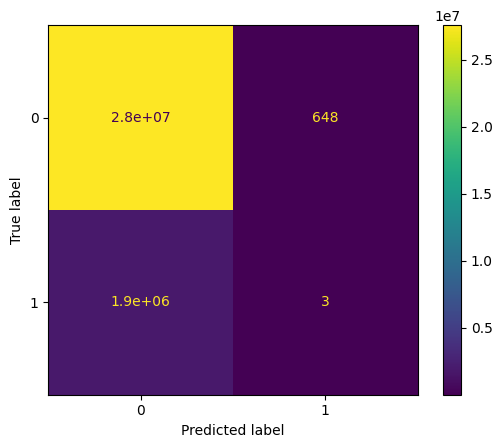

In [33]:
plot_confusion_matrix(model, x_train, y_train)
plt.show()

In [34]:
# predict poorly on 1's
# PR

In [35]:
model_class_balanced = LogisticRegression(class_weight = 'balanced').fit(x_train,y_train)

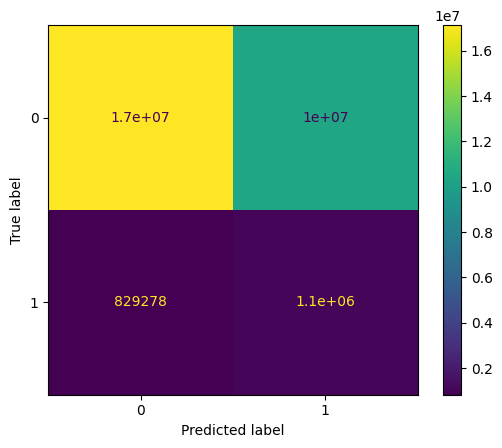

In [36]:
plot_confusion_matrix(model_class_balanced, x_train, y_train)
plt.show()

In [37]:
# train score
model_class_balanced.score(x_train,y_train)

0.617432646356231

In [38]:
#val score
model_class_balanced.score(x_val,y_val)

0.6174683280896688

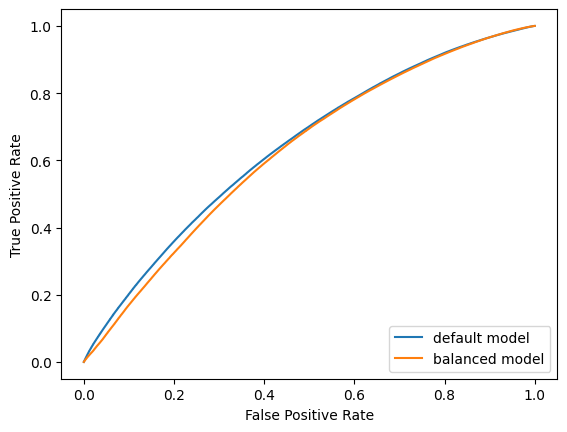

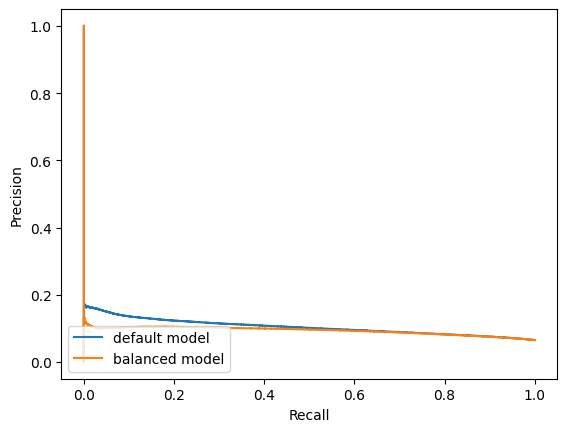

In [44]:
fig, ax = plt.subplots()

y_prob = model.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob, pos_label=1)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name='default model')

y_prob_balanced = model_class_balanced.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob_balanced, pos_label=1)
disp_balanced = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name='balanced model')

plt.show()

fig, ax1 = plt.subplots()

precision, recall, thresholds = precision_recall_curve(y_val, y_prob, pos_label = 1)
dis = PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax1,name='default model')

precision, recall, thresholds = precision_recall_curve(y_val, y_prob_balanced, pos_label = 1)
disp_balanced = PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax1,name='balanced model')

plt.show()

In [54]:
# predict 5 hotel clusters 
def predict_test(model, x, y):
    book_prob = pd.DataFrame(index=x.index)
    for h in range(100):
        x.loc[:,'hotel_cluster'] = h
        book_prob[h] = model_class_balanced.predict_proba(x)[:,1]
    
    top_5 = book_prob.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)

    total_num = len(top_5)
    correct_num = (pd.DataFrame(np.tile(y_test.to_numpy(), (5,1)).T, index=y_test.index) == top_5).sum().sum()
    accuracy = correct_num/total_num
    print('accuracy in testing set: ', accuracy)
    display(top_5)

In [55]:
predict_test(model_class_balanced, x_test, y_test)

accuracy in testing set:  0.050336743999263765


,0,1,2,3,4
3163307,99,98,97,96,95
20717457,99,98,97,96,95
7477332,99,98,97,96,95
5283845,99,98,97,96,95
34619211,99,98,97,96,95
...,...,...,...,...,...
36474137,99,98,97,96,95
30110037,99,98,97,96,95
8417250,99,98,97,96,95
6882609,99,98,97,96,95


In [46]:
book_prob = pd.DataFrame(index=x_test.index)
for h in range(100):
    x_test.loc[:,'hotel_cluster'] = h
    #book_prob = pd.concat([book_prob,model_class_balanced.predict_proba(x_test)[:,1]], axis=1)
    book_prob[h] = model_class_balanced.predict_proba(x_test)[:,1]
    

In [47]:
#book_prob

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
3163307,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
20717457,0.558034,0.558036,0.558038,0.558040,0.558042,0.558044,0.558046,0.558048,0.558050,0.558052,...,0.558212,0.558214,0.558216,0.558218,0.558220,0.558222,0.558224,0.558226,0.558228,0.558230
7477332,0.523384,0.523386,0.523388,0.523390,0.523392,0.523394,0.523396,0.523398,0.523400,0.523402,...,0.523564,0.523566,0.523568,0.523570,0.523572,0.523574,0.523576,0.523578,0.523580,0.523582
5283845,0.970495,0.970495,0.970495,0.970496,0.970496,0.970496,0.970496,0.970497,0.970497,0.970497,...,0.970516,0.970516,0.970516,0.970516,0.970517,0.970517,0.970517,0.970517,0.970517,0.970518
34619211,0.973105,0.973105,0.973105,0.973105,0.973106,0.973106,0.973106,0.973106,0.973106,0.973107,...,0.973124,0.973124,0.973124,0.973124,0.973124,0.973125,0.973125,0.973125,0.973125,0.973126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36474137,0.970769,0.970769,0.970769,0.970769,0.970769,0.970770,0.970770,0.970770,0.970770,0.970771,...,0.970789,0.970789,0.970789,0.970790,0.970790,0.970790,0.970790,0.970791,0.970791,0.970791
30110037,0.916612,0.916612,0.916613,0.916614,0.916614,0.916615,0.916616,0.916616,0.916617,0.916617,...,0.916667,0.916668,0.916668,0.916669,0.916670,0.916670,0.916671,0.916671,0.916672,0.916673
8417250,0.988240,0.988240,0.988240,0.988240,0.988240,0.988240,0.988240,0.988240,0.988240,0.988240,...,0.988248,0.988248,0.988248,0.988248,0.988248,0.988248,0.988248,0.988249,0.988249,0.988249
6882609,0.925473,0.925473,0.925474,0.925474,0.925475,0.925475,0.925476,0.925476,0.925477,0.925478,...,0.925522,0.925523,0.925523,0.925524,0.925525,0.925525,0.925526,0.925526,0.925527,0.925527


In [48]:
#top_5 = book_prob.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)

In [49]:
#top_5

,0,1,2,3,4
3163307,99,98,97,96,95
20717457,99,98,97,96,95
7477332,99,98,97,96,95
5283845,99,98,97,96,95
34619211,99,98,97,96,95
...,...,...,...,...,...
36474137,99,98,97,96,95
30110037,99,98,97,96,95
8417250,99,98,97,96,95
6882609,99,98,97,96,95


In [50]:
#y_test

3163307     15
20717457    67
7477332     43
5283845     77
34619211     0
            ..
36474137    48
30110037    11
8417250      5
6882609     21
2081966      9
Name: hotel_cluster, Length: 597635, dtype: category
Categories (100, int64): [0, 1, 2, 3, ..., 96, 97, 98, 99]

In [51]:
#y_test[y_test.isin(top_5)]

34619211    0
1553634     1
466850      1
14419753    2
22014303    2
           ..
26814325    0
6427296     1
34524237    0
26790910    2
13342000    1
Name: hotel_cluster, Length: 30083, dtype: category
Categories (100, int64): [0, 1, 2, 3, ..., 96, 97, 98, 99]

In [52]:
#total_num = len(top_5)
#correct_num = len(y_test[y_test.isin(top_5)])
#accuracy = correct_num/total_num
#accuracy

0.050336743999263765

In [53]:
#display(top_5)

,0,1,2,3,4
3163307,99,98,97,96,95
20717457,99,98,97,96,95
7477332,99,98,97,96,95
5283845,99,98,97,96,95
34619211,99,98,97,96,95
...,...,...,...,...,...
36474137,99,98,97,96,95
30110037,99,98,97,96,95
8417250,99,98,97,96,95
6882609,99,98,97,96,95


* 5% accuracy is very low, the model underestimates the difference between hotel clusters. Would try other methods